# Grain Size Distribution - Height Correlation Function

Find relevant parameters describing the topography of sputtered Ruthenium thin films on Si substrate
How:
- Roughness RMS
- Fit exponential increase
- Take intersection between RMS asymptote and Fit

Output parameters:
- Roughness
- Correlation Length
- Alpha exponent

In [1]:
import os
import sys
import json

import numpy as np
import pandas as pd
import pickle

%matplotlib nbagg
%reload_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

from matplotlib import cm
from skimage import data, img_as_float, io, util, segmentation, color, draw, filters

from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

In [2]:
debug = True #or 'False' when you do not want to debug

path = "/Users/sfiligoj/Desktop/SEM_all"
os.chdir(path)
filess = os.listdir()
filess = [f for f in filess if (f.endswith('tif') and '*' not in f)]
print(f"Found {len(filess)} files")

Found 151 files


In [3]:
# read-in the dictionary of Scan Size values:
with open('FOVs.json', 'r') as f:
    FOV_dict = json.loads(f.read())

In [5]:
# We create the empty DataFrame:
df = pd.DataFrame(
        columns= ['filename', 'density', 'temp', 'hhcorr', 'scansize', 'n_pix'])

for i,file in enumerate(filess[:]):
    print(f'running file: {file}')
    
    # Parses information from filename
    if 'L_' in file:
        density = 'L'
        if 'asdep' in file:
            temperature = '25'
        else:
            temperature = file[2:5]
        
    if 'H_' in file:
        density = 'H'
        if 'asdep' in file:
            temperature = '25'
        else:
            temperature = file[2:5]

    if 'Ru_LH' in file:
        density = 'LH'
        if 'asdep' in file:
            temperature = '25'
        else:
            temperature = file[6:9]
    
    print(f'density: {density} and temperature {temperature}')

        
    img = io.imread(file, as_gray=True)
    img = np.copy(img[:1024,:])
    
    N_Pixel = img.shape[0]                              # before was len(data), which works in this case, but it would be the N of rows 
    ScanSize = FOV_dict[file]
    StepSize = ScanSize/N_Pixel                          # nm/px     
        
    Xdelta = np.linspace(StepSize, ScanSize, num=N_Pixel)
    
    # ***    Calculate Height-Height correlation function:   ***

    HHcorr = np.zeros(N_Pixel, dtype='float')
    for px_dist in range(0, N_Pixel-1):
        shifted_data = img[:,px_dist+1:].astype(float)
        data_section = img[:,:-px_dist-1].astype(float)
        difference = (data_section-shifted_data)**2
        HHcorr[px_dist] = np.mean(difference)
    # The last point of HHcorr is always 0, so we work around it:
    HHcorr[-1] = HHcorr[-2]
    
    df = df.append( 
            {'filename': file , 
             'density': density, 
             'temp': temperature, 
             'hhcorr': HHcorr , 
             'scansize': ScanSize , 
             'n_pix': N_Pixel, 
            },
            ignore_index=True)
    

running file: H_asdep_006.tif
density: H and temperature 25
running file: Ru_LH_500C_015.tif
density: LH and temperature 500
running file: Ru_LH_700C_077.tif
density: LH and temperature 700
running file: L_asdep_007.tif
density: L and temperature 25
running file: H_700C_024.tif
density: H and temperature 700
running file: H_700C_1um_047.tif
density: H and temperature 700
running file: Ru_LH_700C_089.tif
density: LH and temperature 700
running file: L_asdep_006.tif
density: L and temperature 25
running file: Ru_LH_700C_076.tif
density: LH and temperature 700
running file: Ru_LH_500C_014.tif
density: LH and temperature 500
running file: L_700C_300nm_058.tif
density: L and temperature 700
running file: H_asdep_007.tif
density: H and temperature 25
running file: Ru_LH_600C_018.tif
density: LH and temperature 600
running file: H_asdep_005.tif
density: H and temperature 25
running file: H_800C_10um_107.tif
density: H and temperature 800
running file: L_700C_1um_055.tif
density: L and tempera

running file: Ru_LH_700C_087.tif
density: LH and temperature 700
running file: Ru_LH_800C_031.tif
density: LH and temperature 800
running file: Ru_LH_800C_025.tif
density: LH and temperature 800
running file: Ru_LH_800C_024.tif
density: LH and temperature 800
running file: Ru_LH_700C_092.tif
density: LH and temperature 700
running file: Ru_LH_800C_030.tif
density: LH and temperature 800
running file: Ru_LH_700C_086.tif
density: LH and temperature 700
running file: H_250C_008.tif
density: H and temperature 250
running file: Ru_LH_700C_079.tif
density: LH and temperature 700
running file: L_700C_300nmm_057.tif
density: L and temperature 700
running file: H_500C_500nm_031.tif
density: H and temperature 500
running file: Ru_LH_600C_017.tif
density: LH and temperature 600
running file: Ru_LH_700C_090.tif
density: LH and temperature 700
running file: Ru_LH_800C_026.tif
density: LH and temperature 800
running file: Ru_LH_800C_032.tif
density: LH and temperature 800
running file: H_500C_5000nm

In [6]:
# Save a dictionary into a pickle file.
pickle.dump(df, open( "save.p", "wb" ) )
df

,filename,density,temp,hhcorr,scansize,n_pix
0,H_asdep_006.tif,H,25,"[32176324.873505574, 34862881.42919412, 358437...",345,1024
1,Ru_LH_500C_015.tif,LH,500,"[30971148.212057844, 39822527.95124445, 495364...",829,1024
2,Ru_LH_700C_077.tif,LH,700,"[9848706.73064116, 10840572.095596174, 1142325...",414,1024
3,L_asdep_007.tif,L,25,"[30357561.39386833, 35315579.13675822, 3528665...",11800,1024
4,H_700C_024.tif,H,700,"[30515781.720810007, 33113456.48294899, 340378...",518,1024
...,...,...,...,...,...,...
146,H_500C_5000nm_032.tif,H,500,"[44808158.615319625, 63280694.73080361, 717283...",6380,1024
147,Ru_LH_800C_033.tif,LH,800,"[12565847.287315503, 21418237.29229967, 335554...",1180,1024
148,Ru_LH_800C_027.tif,LH,800,"[8141302.405999338, 9122066.375893166, 9837509...",345,1024
149,H_700C_10um_043.tif,H,700,"[48778316.37116373, 59257170.47487293, 6164407...",16600,1024


<IPython.core.display.Javascript object>


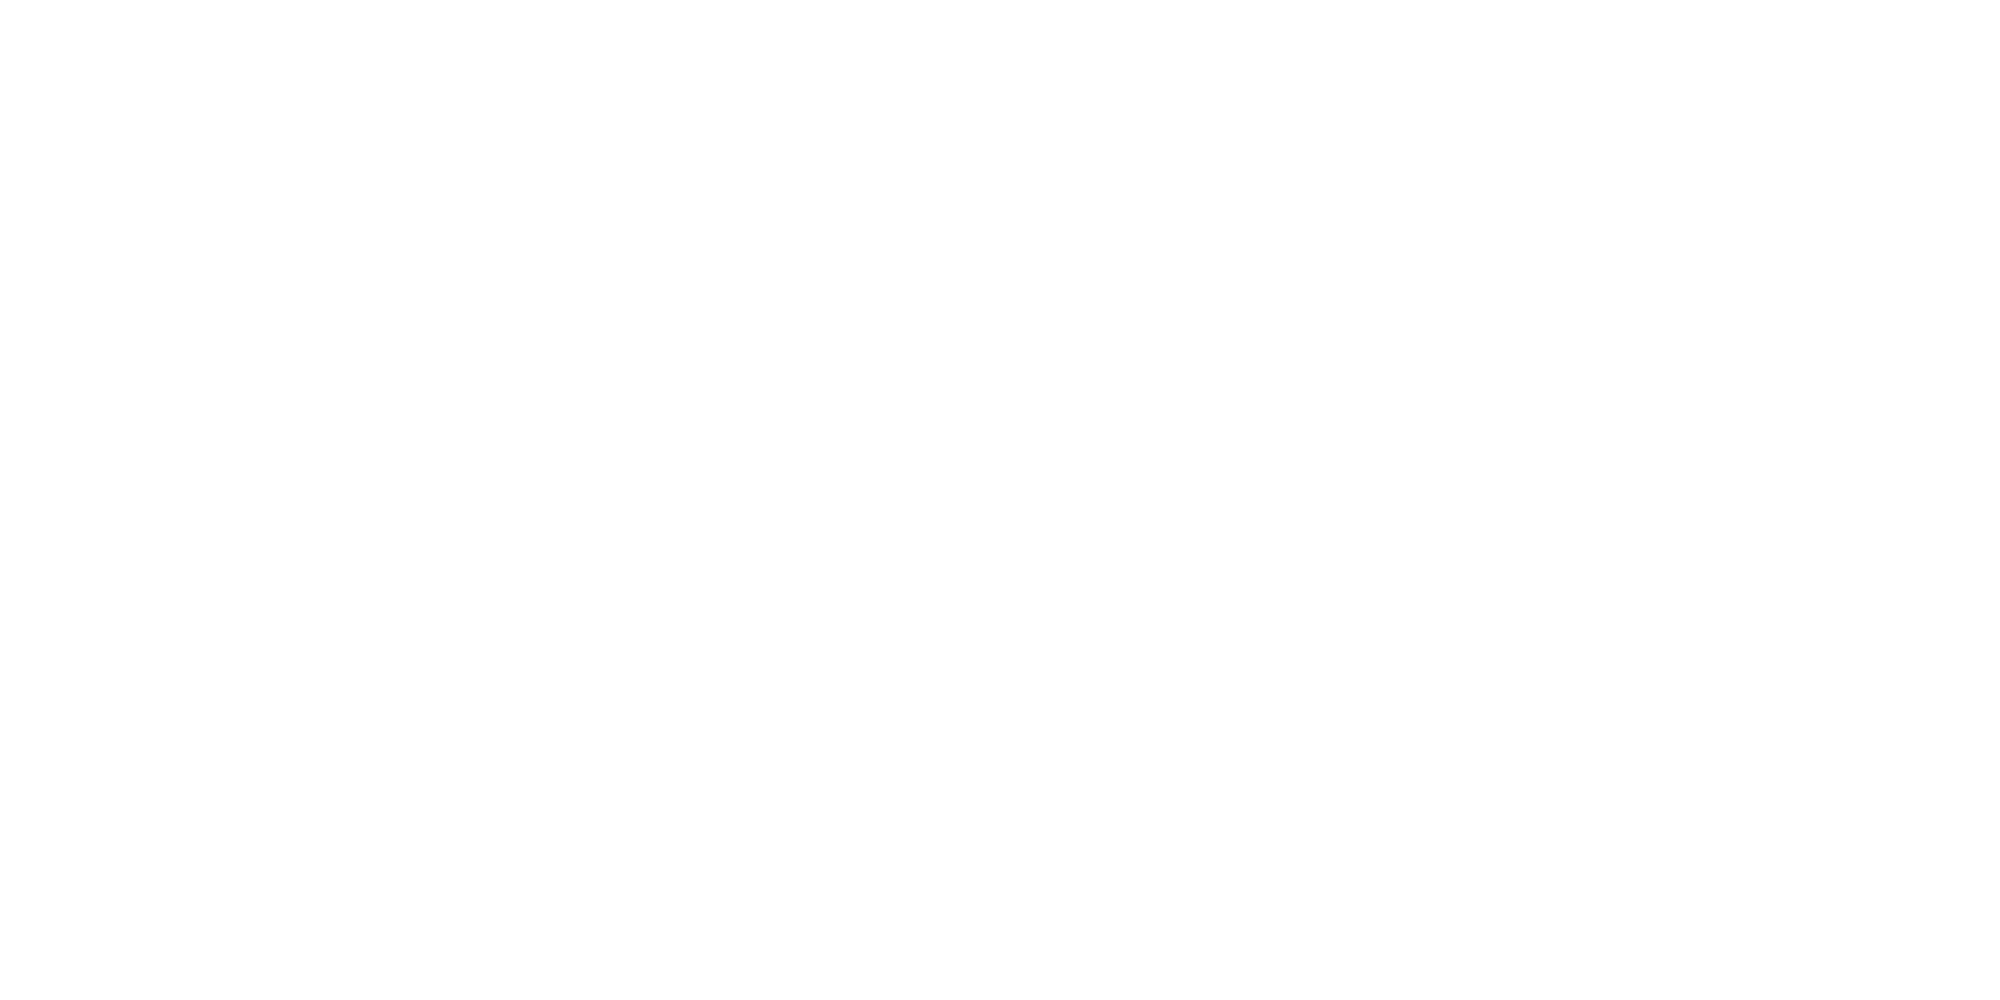

<IPython.core.display.Javascript object>


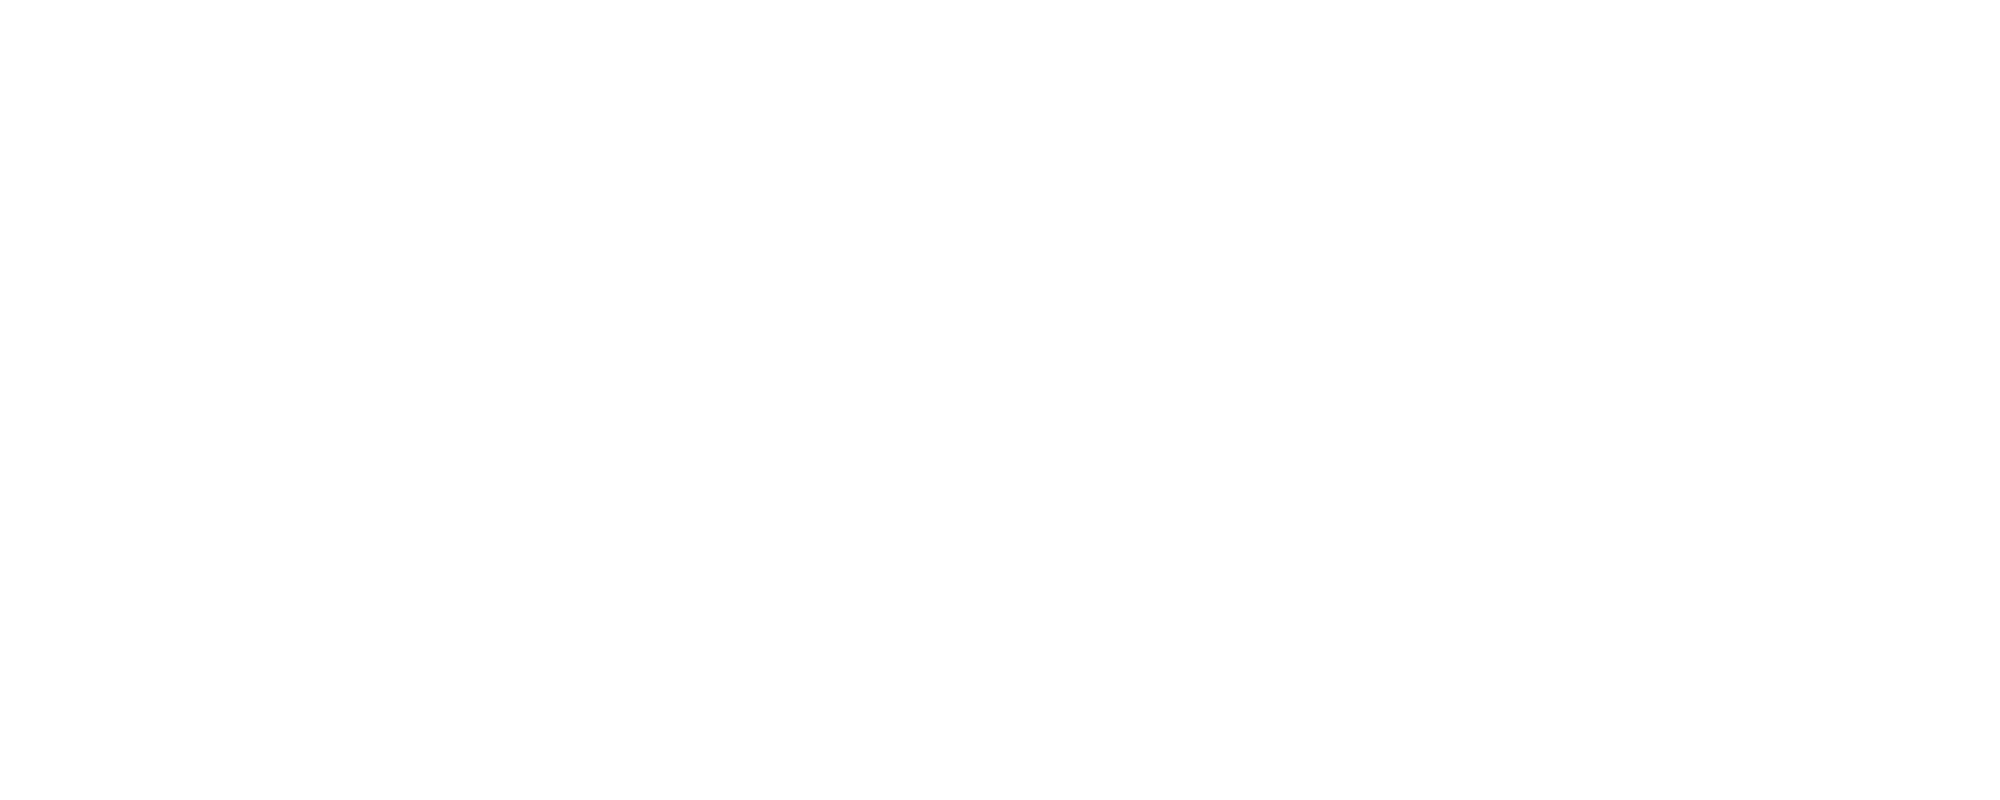

<IPython.core.display.Javascript object>


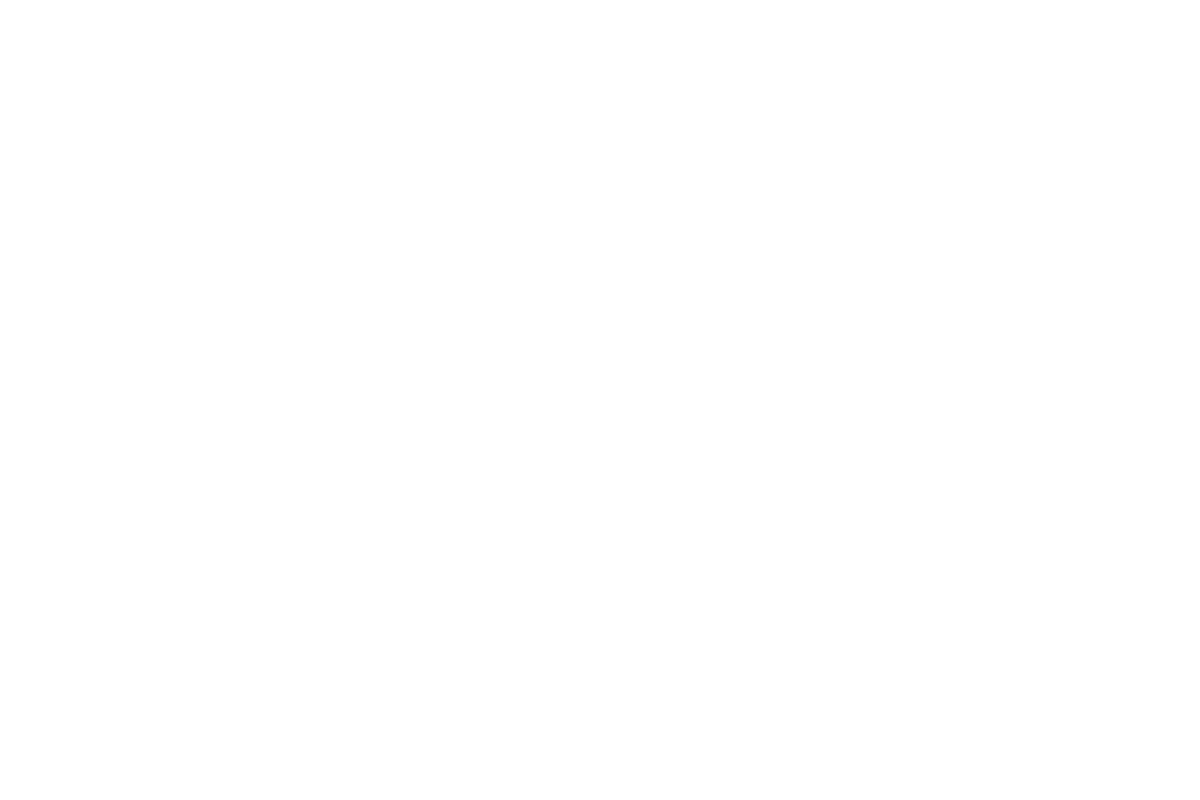

<IPython.core.display.Javascript object>


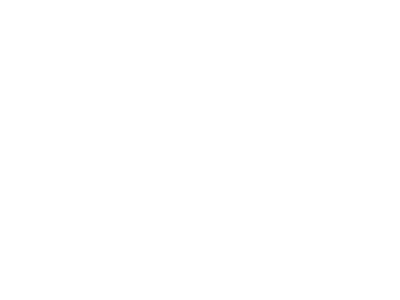

<IPython.core.display.Javascript object>


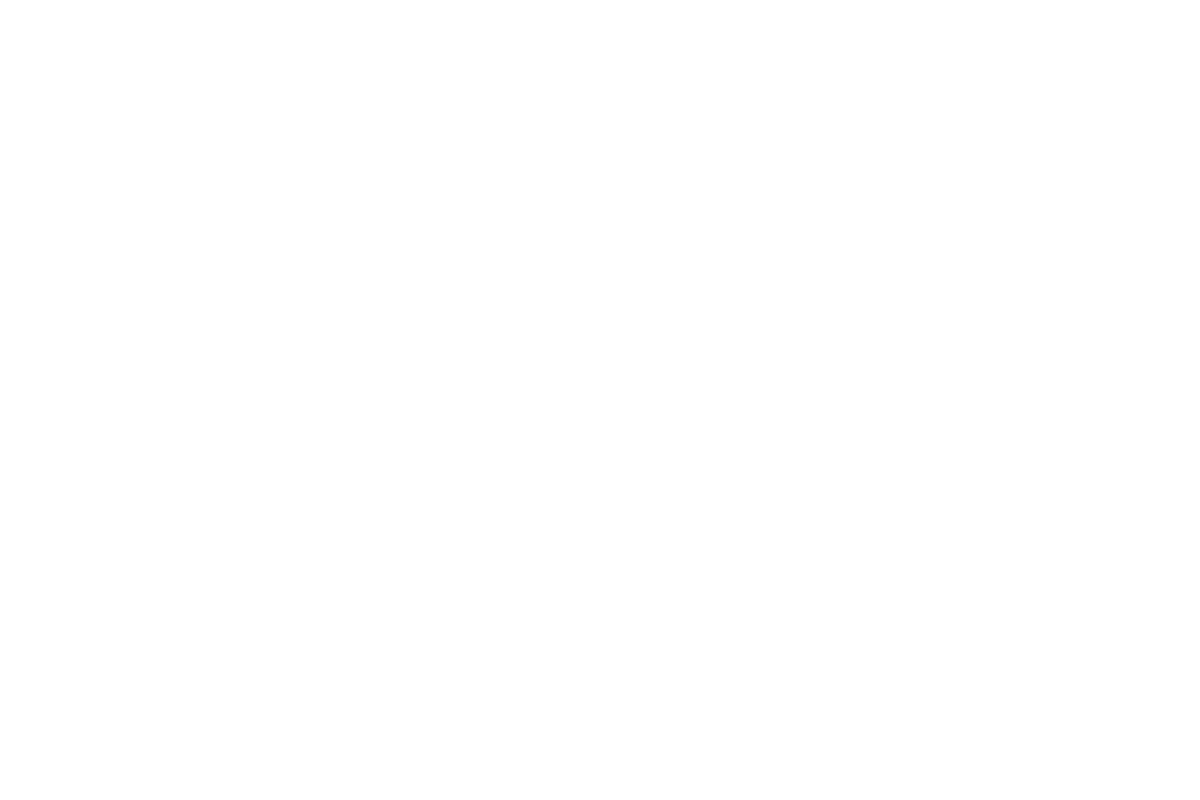

<IPython.core.display.Javascript object>

In [ ]:
import pandas_profiling
from pathlib import Path
profile = df.profile_report(title="SEMdata")
profile.to_file(output_file=Path("./SEMdata.html"))